<a href="https://colab.research.google.com/github/Karthick47v2/mock-buddy/blob/main/Data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install kaggle
!pip3 install kaggle

# copy kaggle.json to required dir and give permission
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# download dataset
!kaggle datasets download selfishgene/youtube-faces-with-facial-keypoints

100% 16.2G/16.2G [02:06<00:00, 176MB/s]
100% 16.2G/16.2G [02:06<00:00, 138MB/s]


In [3]:
# unzip
!unzip youtube-faces-with-facial-keypoints.zip

Archive:  youtube-faces-with-facial-keypoints.zip
  inflating: youtube_faces_with_keypoints_full.csv  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/AJ_Cook_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/AJ_Cook_2.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_1.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abba_Eban_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abba_Eban_5.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abdel_Aziz_Al-Hakim_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abdel_Aziz_Al-Hakim_1.npz  
  inflating: youtube_faces_with_keypoints_full_1/

In [1]:
# import libs
# data visualization
import pandas as pd
# easy file access
import glob
# np array
import numpy as np
# plot
import matplotlib.pyplot as plt
# image processing
import cv2

In [2]:
# read csv
csv_file = pd.read_csv('/content/youtube_faces_with_keypoints_full.csv')

In [ ]:
csv_file.head(10)

In [ ]:
print("Total videos : ", csv_file.shape[0])
print("Unique videos : ", len(csv_file['personName'].unique()))

In [3]:
# make sure there are no unwanted npz files in the directory coz we are going to search the whole dir for npz files
# using iglob to prevent unnecessary load to RAM
npz_path_list = glob.glob('/content/**/*.npz', recursive=True)

In [4]:
# get all video id
# npzPathList contains path -> xxxx/xxxx/xxx/yyy.npz....we need yyy ...
# inorder to get that
# get yyy.npz (split by '/' and get last element)
# get yyy (split by '.' and get 1st element)
vidIDs = [x.split('/')[-1].split('.')[0] for x in npz_path_list]

In [5]:
# now map video id with full path (csv contains vidID so we need it to map with path)
vid_paths = {}

for vidID, vid_path in zip(vidIDs, npz_path_list):
  vid_paths[vidID] = vid_path

In [6]:
# just making sure no data is missing
csv_file = csv_file.loc[csv_file.loc[:, 'videoID'].isin(vid_paths.keys()), :].reset_index(drop=True)

In [ ]:
# get hands-on the data AKA play with data
# visualize 4 frames of 4 different videos with landmarks
np.random.seed(42)
num_vids = 4
num_frames = 4
frames_list = np.array([0.1, 0.3, 0.6, 0.9])

# get rand vid ids
sample_vids = csv_file.loc[np.random.choice(csv_file.index, size=num_vids, replace=False), 'videoID']

In [11]:
# lets see the size of single frame and landmarks obj
for i, vidID in enumerate(csv_file['videoID']):
  if i == 1:
    break

  np_file = np.load(vid_paths[vidID])
  col_img = np_file['colorImages']
  landmarks2D = np_file['landmarks2D']
  
  frame_h, frame_w = col_img[:, :, :, 0].shape[:2]
  scale_h, scale_w = 192 / frame_h, 192 / frame_w

  landmarks = landmarks2D[:, :, 0]
  landmarks[:, 0] = landmarks[:, 0] * scale_w
  landmarks[:, 1] = landmarks[:, 1] * scale_h 
  landmarks = landmarks.astype(np.float32)
  print(landmarks.size, landmarks.itemsize, landmarks.size * landmarks.itemsize, 'bytes')

  frames = (cv2.resize(col_img[:, :, :, 0], (192, 192))).astype(np.uint8)
  print(frames.size, frames.itemsize, frames.size * frames.itemsize, 'bytes')

136 4 544 bytes
110592 1 110592 bytes


In [ ]:
# visualize data using matplotlib
fig, arr = plt.subplots(nrows=num_vids, ncols=num_frames, figsize=(14,18))

for i, videoID in enumerate(sample_vids):
  # load nparray
  np_file = np.load(vid_paths[videoID])
  # it contains colorimages, boundingbox, landmarks2D
  # color image shape is 4 (x, y, RGB, no_of_frames)
  col_img = np_file['colorImages']
  landmarks = np_file['landmarks2D']

  # generate color image from np array (uin8 -> 0 - 255)
  frames = (frames_list * (col_img.shape[3] - 1)).astype(np.uint8)

  # generate image, landmarks
  for j, frame in enumerate(frames):
    arr[i][j].imshow(col_img[:, :, :, frame])
    arr[i][j].scatter(x=landmarks[:,0,frame], y=landmarks[:, 1, frame], s=3, c='r')

In [7]:
# save resized images and resized landmarks separately for future usage
# total 2194 -- but i am taking 2000 video files and getting each 45th frame from each video (0, 45, 90..)
# so total training datatset length ~ 6350 (224x224x3 np format)
frames = []
landmark_xy = []
img_size = 224     # resize all frames to 224 x 224
frame_cut = 30

for i, vidID in enumerate(csv_file['videoID']):
  # as it contains each frames of video, we can omit many frames 
  # here i am only using 1 frame per video

  np_file = np.load(vid_paths[vidID])
  col_img = np_file['colorImages']
  landmarks2D = np_file['landmarks2D']
  
  n = int(((col_img.shape[3] - 1) / frame_cut) + 1)
  for j in range(n):
    frame_h, frame_w = col_img[:, :, :, j * frame_cut].shape[:2]
    scale_h, scale_w = img_size / frame_h, img_size / frame_w

    landmarks = landmarks2D[:, :, j * frame_cut]
    landmarks[:, 0] = landmarks[:, 0] * scale_w
    landmarks[:, 1] = landmarks[:, 1] * scale_h 
    landmark_xy.append(landmarks.astype(np.float32))

    frames.append(cv2.resize(col_img[:, :, :, j * frame_cut], (img_size, img_size)).astype(np.uint8))

frames = np.array(frames).astype(np.uint8)
landmark_xy = np.array(landmark_xy).astype(np.float32)

In [9]:
# arrage to model train format
y_data = landmark_xy.reshape(landmark_xy.shape[0], -1)
y_train = np.reshape(y_data, (-1, 1, 1, 136)) / img_size

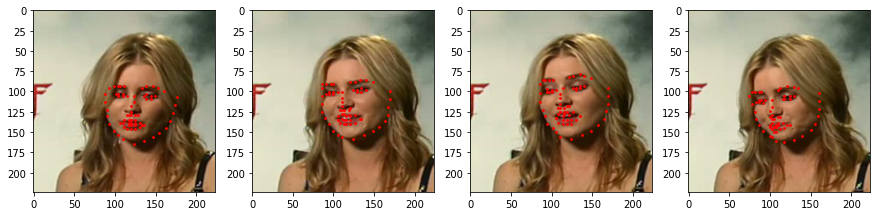

In [10]:
#check 
fig, arr = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  arr[i].imshow(frames[i])
  x = np.reshape(y_train[i, :, :, np.arange(0, 136, 2)], (68)) * img_size
  y = np.reshape(y_train[i, :, :, np.arange(1, 136, 2)], (68)) * img_size
  arr[i].scatter(x, y, s=3, c='r')

In [11]:
# save np array for future use (training model)
np.save('frames30.npy', frames)
np.save('y_train30.npy', y_train)

In [ ]:
# move the saved files to google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [14]:
!mv y_train30.npy frames30.npy /content/gdrive/MyDrive/data-v/

In [16]:
# save resized images and resized landmarks separately for test dataset
# here taking only 1 frame from each vid file. (upto 100 vids)
test_frames = []
test_bbox = []
img_size = 224     # resize all frames to 224 x 224

for i, vidID in enumerate(csv_file['videoID']):
  # as it contains each frames of video, we can omit many frames 
  # here i am only using 1 frame per video

  if i == 100:
    break

  np_file = np.load(vid_paths[vidID])
  col_img = np_file['colorImages']
  frame_h, frame_w = col_img[:, :, :, 0].shape[:2]
  scale_h, scale_w = img_size / frame_h, img_size / frame_w

  test_frames.append(cv2.resize(col_img[:, :, :, 3], (img_size, img_size)).astype(np.uint8))

test_frames = np.array(test_frames).astype(np.uint8)

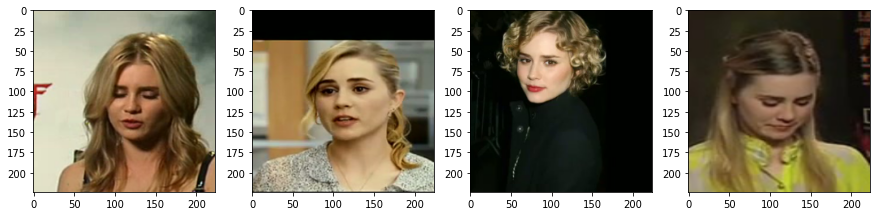

In [18]:
fig,arr = plt.subplots(nrows=1,ncols=4,figsize=(15,15))
for i in range(4):
    arr[i].imshow(test_frames[i])



In [22]:
# save np array for future use (testing model)
np.save('test_frames.npy', test_frames)

In [23]:
!mv test_frames.npy /content/gdrive/MyDrive/data-v/